In [56]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cv2
from PIL import Image
import tifffile
import json
import torchvision.transforms as transforms

In [3]:
data_dir = '../data'
image_dir = os.path.join(data_dir,'train_images')
label_dir = os.path.join(data_dir, 'train_annotation')
meta_path = os.path.join(data_dir,'train.csv')

In [58]:
meta_df = pd.read_csv(meta_path).sort_values(by = 'id')
meta_df

,id,organ,data_source,img_height,img_width,pixel_size,tissue_thickness,rle,age,sex
302,62,kidney,HPA,3000,3000,0.4,4,4382055 23 4385050 34 4388048 44 4391045 57 43...,59.0,Male
35,127,lung,HPA,3000,3000,0.4,4,4237495 6 4240494 9 4243491 14 4246490 17 4249...,21.0,Male
48,144,spleen,HPA,3000,3000,0.4,4,1273039 14 1276037 18 1279035 23 1282034 26 12...,50.0,Female
70,164,kidney,HPA,3000,3000,0.4,4,1539720 16 1542718 22 1545717 25 1548716 33 15...,61.0,Male
107,203,largeintestine,HPA,3000,3000,0.4,4,610617 10 613607 28 616602 38 619600 43 622597...,84.0,Female
...,...,...,...,...,...,...,...,...,...,...
264,32231,spleen,HPA,3000,3000,0.4,4,1399958 26 1402957 29 1405956 32 1408947 48 14...,72.0,Male
265,32325,kidney,HPA,3000,3000,0.4,4,1405200 12 1408197 18 1411188 66 1414184 81 14...,56.0,Female
266,32412,prostate,HPA,3000,3000,0.4,4,2888331 67 2891325 76 2894320 84 2897303 104 2...,48.0,Male
267,32527,kidney,HPA,3000,3000,0.4,4,595536 12 598536 16 601536 19 604526 33 607518...,41.0,Female


In [59]:
#Images that don't have the size of the majority (3000*3000)

for image_name in os.listdir(image_dir):
    image = tifffile.imread(os.path.join(image_dir,image_name))
    if image.shape != (3000,3000,3):
        print(image_name[:-5],image.shape)

11645 (2867, 2867, 3)
1229 (2654, 2654, 3)
12784 (2727, 2727, 3)
14396 (2680, 2680, 3)
14756 (2539, 2539, 3)
15860 (2631, 2631, 3)
16149 (2790, 2790, 3)
17455 (2942, 2942, 3)
18121 (2308, 2308, 3)
18777 (2790, 2790, 3)
21112 (2942, 2942, 3)
2344 (2764, 2764, 3)
23760 (2764, 2764, 3)
2668 (2783, 2783, 3)
28318 (2869, 2869, 3)
28622 (2654, 2654, 3)
28657 (2760, 2760, 3)
28748 (2630, 2630, 3)
28963 (2511, 2511, 3)
29296 (2416, 2416, 3)
5102 (2631, 2631, 3)
5317 (2416, 2416, 3)
6794 (2593, 2593, 3)
9450 (2675, 2675, 3)
9769 (3070, 3070, 3)


In [6]:
output_dir = '../data/preproc'

In [50]:
def resizer(im_name,shape):
    '''
    The resizer takes in 2 args:
    im_name- name of the image
    scale- percentage by which the image has to be reduced
    '''
    image_path = os.path.join(image_dir, im_name +'.tiff')
    im_read = tifffile.imread(image_path)
    print('File name: {}, original size: {}, resized to: {}'.format(im_name , (im_read.shape[0], im_read.shape[1]), shape))
    resized = cv2.resize(im_read, shape, interpolation=cv2.INTER_AREA)
    image_path = os.path.join(output_dir, ('r_' + im_name +'.tiff'))
    tifffile.imwrite(image_path, resized)

In [52]:
def rle2mask(rle,shape):
    ## to see a complete code breakdown, REFER version 3.
    s = rle.split()
    # the "s" here is of dtype('<U7') hence we convert it to "int"
    # very very important step 
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T

def resize_mask(im_name,shape):
    '''
    reads RLE encodings from the df
    converts to masks and resizes it to a scaling_percentage of original size
    '''
    im_read = tifffile.imread(os.path.join(image_dir, im_name +'.tiff'))
    mask_rle = meta_df[meta_df["id"] == int(im_name)]["rle"].values[0]
    mask = rle2mask(mask_rle, (im_read.shape[1], im_read.shape[0]))*255
    print('File name: {}, original size: {}, resized to: {}'.format(im_name, (im_read.shape[0], im_read.shape[1]), shape))
    resized = cv2.resize(mask, shape, interpolation=cv2.INTER_AREA)
    image_path = os.path.join(output_dir, (im_name + '.tiff'))
    tifffile.imwrite(image_path, resized) 

In [9]:
def show_image(image_id,cmaps):
    fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(16, 32))
    image_path = os.path.join(output_dir, 'r_{}.tiff'.format(image_id))
    mask_path = os.path.join(output_dir, '{}.tiff'.format(image_id))    
    image = tifffile.imread(image_path)
    mask = tifffile.imread(mask_path)
    hybr = image[:, :,0]/2 + mask[:, :]

    ax[0].imshow(image)
    ax[0].axis('off')
    ax[0].set_title('IMAGE')
    ax[1].imshow(hybr,cmap=cmaps)
    ax[1].axis('off')
    ax[1].set_title('MASK ON IMAGE')
    plt.show()    

File name: 10044, original size: (3000, 3000), resized to: (3000, 3000)
File name: 10044, original size: (3000, 3000), resized to: (3000, 3000)


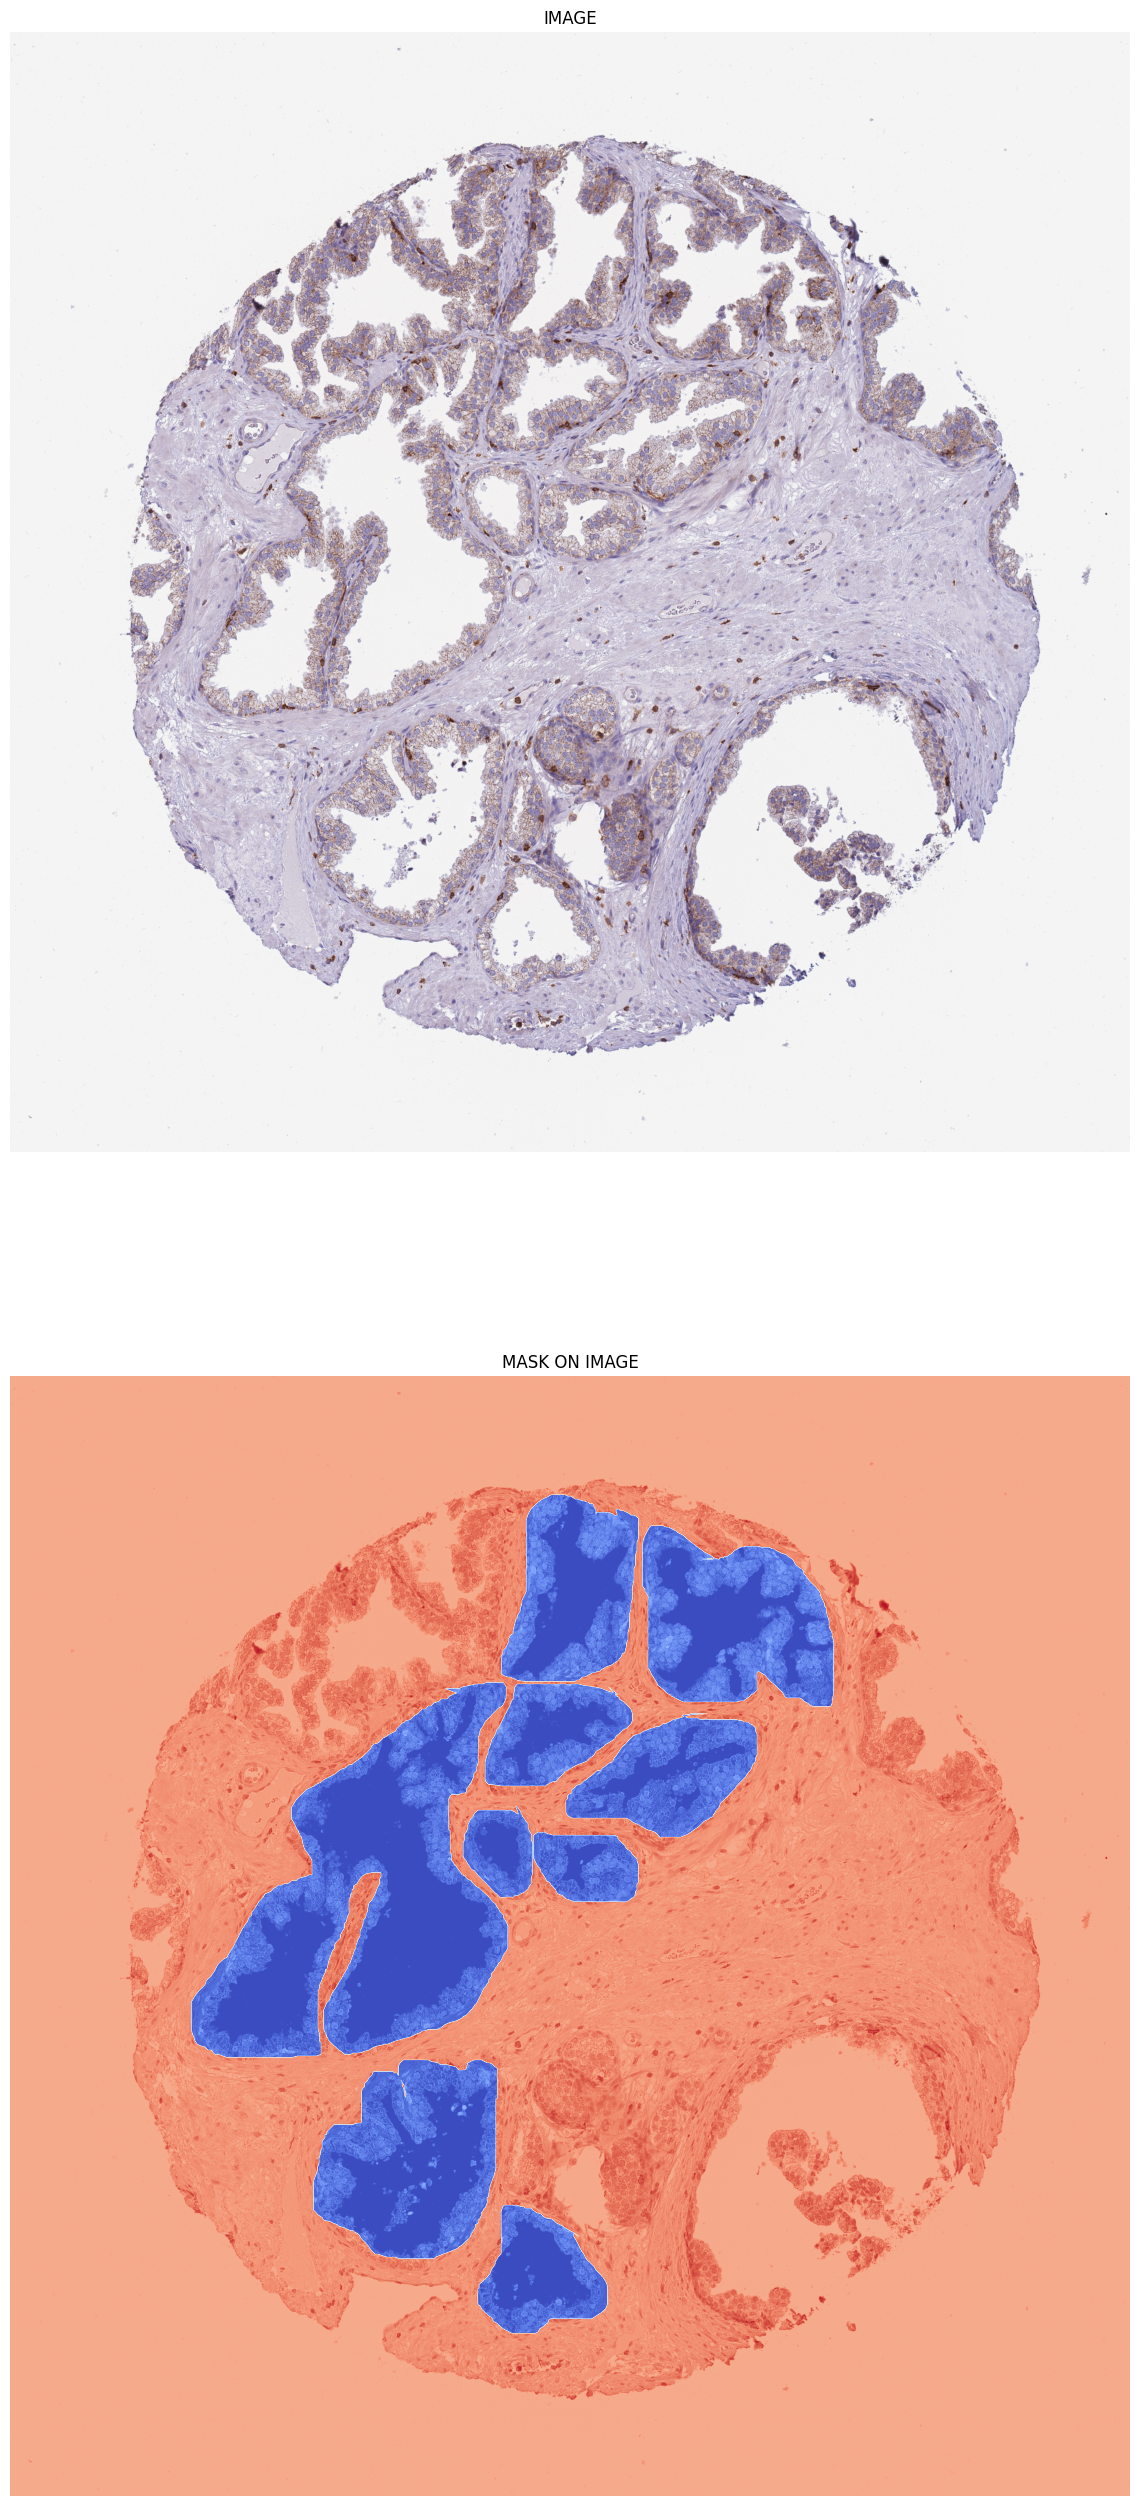

torch.Size([1, 3000, 3000])


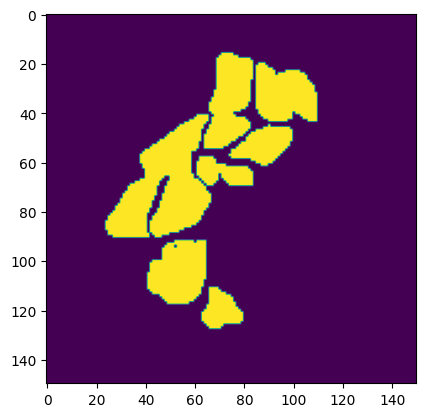

In [53]:
resizer('10044',(3000,3000))
resize_mask('10044', (3000,3000))
show_image('10044','coolwarm_r')

mask = rle2mask(meta_df[meta_df["id"] == int('10044')]["rle"].values[0],(3000,3000))
mask = torch.tensor([mask])
print(mask.shape)
#plt.imshow(mask,cmap='gray')
data_transform = transforms.Compose([
    transforms.Resize(size=(150,150))
])
mask = data_transform(mask)
plt.imshow(mask[0])

In [ ]:
for mask in os.li